# N-BEATS Lightninig M4

**N-BEATS** N- is a neural network based time series forecasting algorithm that was introduced in a paper by Oreshkin, et al. The algorithm has shown strong performance on a variety of time series forecasting benchmarks.

In this notebook, we will explore the Pytorch Lightning implementation of the N-BEATS algorithm, and apply it to the Monthly dataset from the M4 Time series analysis competition.

### N-BEATS Algorithm
N-BEATS consists of a stack of fully connected neural network blocks, where each block is trained to forecast the target time series. The unique aspect of N-BEATS is its ability to handle a wide range of time series forecasting problems without requiring any prior knowledge about the data.  Therefore, N-BEATS, unlike other neural network based forecasting algorithms, does not require any feature engineering or scaling of the data.  The algorithm is also able to handle multiple seasonalities and long term trends.


### M4 Competition

The **M4 Competition** is a well-known benchmark in the time series forecasting community. The competition, which took place in 2018, was the fourth iteration of the Makridakis Competitions, named after forecasting expert Spyros Makridakis. The M4 competition built upon the legacy of the previous M-Competitions (M1, M2, and M3) by providing a large dataset consisting of 100,000 time series from a variety of domains including finance, economics, demography, and others.

The primary objective of the competition was to identify the most accurate and robust forecasting methods for time series data, and to introduce deep learning into the analysis techniques, Participants were challenged to develop forecasting models that could perform well across a broad range of time series data with varying characteristics.

This competition attracted a considerable number of participants from across the globe, including academics, practitioners, and organizations, further advancing the field of time series forecasting by unveiling novel methods and insights. N-BEATS was not one entries into the competition, as the paper was published a year after its conclusion.  However, teh authors demonstrated state-of-the-art performance with N-BEATS for all the datasets in M4, improving forecast accuracy by 11% over a statistical benchmark and by 3% over the winner of the M4 competition. Unlike M4's winner, N-BEATS does not employ any time-series-specific components and its performance suggests that deep learning primitives such as residual blocks are by themselves sufficient to solve a wide range of forecasting problems. The Generic N-BEATS model used in this notebook uses as little prior knowledge as possible, with no feature engineering, no scaling, and no internal architectural components that may be considered time series specific.

### M4 Dataset

The M4 dataset comprises a collection of time series data intended for the M4 Forecasting Competition. This dataset is divided into three categories: Yearly, Quarterly, and Monthly data, with a total of 100,000 time series. Each time series varies in length, with the minimum, mean, and maximum lengths specified for each category. The dataset aims to provide a comprehensive basis for evaluating and comparing the performance of various forecasting methods.  The dataset is included unmodified in this repository, and can be found in the `nbeats_lightning/data` directory.

In [18]:
import tensorboard as tb
from nbeatslightning import NBeatsNet
from nbeatslightning.data import M4Dataset
from nbeatslightning.loaders import *
from utils import *

import torch
import numpy as np
import pandas as pd
import seaborn as sns

import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import loggers as pl_loggers


from tqdm.notebook import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


The M4-info.csv file contains metadata for the M4 dataset, which consist of 6 individual files, one for each of the Yearl, Quarterly, Monthly, Weekly, Daily, and Hourly observation requencies. The metadata provides information about the time series in each file, including the category, frequency, starting date, forecasting horizon, seasonality, and length of each time series.

Here are the names and descriptions of each of the columns in the M4-info.csv file:

- *M4id*: The unique identifier for each time series in the M4 dataset.
- *Category*: The category to which each time series belongs (Yearly, Quarterly, or Monthly).
- *Frequency*: The frequency of the observations in each time series.
- *StartingDate*: The starting date of each time series. Initially not provided in M4, but added aterwards when the competitive implementations were made available.
- *ForecastHorizon*: The forecasting horizon for each time series, indicating the number of periods ahead that forecasts are required.
- *Seasonality*: The seasonality of each time series, indicating the number of periods in a seasonal cycle.
- *Length*: The total number of observations in each time series.


In [19]:
# Select a seasonal period to train on
# Hourly, Daily, Weekly, Monthly, Quarterly, or Yearly
seasonal_period= "Yearly"

# The backcast length is determined by multiplying the forecast horizon by an integer multiplier
forecast_multiplier = 5

# Set to a category name to train on a single M4 category to train against
# Macro, Micro, Industry, Finance, Demographic, Other, or All
category = 'All' 

dataset_id = 'M4'

In this notebook we will build a model to analyze the M4 Yearly dataset.  There are some built-in convience functions in the package to accomodate eaisly testing N-Beats architectures against the M4 dataset.

In [20]:
# use convience function to load the data
m4 = M4Dataset(seasonal_period, category)
backcast_length = m4.forecast_length * forecast_multiplier  
train_data = m4.train_data
test_data = m4.test_data

m4.train_df.tail()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V827,V828,V829,V830,V831,V832,V833,V834,V835,V836
V1,,,,,,,,,,,,,,,,,,,,,
Y22996,470.0,500.0,572.0,572.0,609.0,664.0,795.0,841.0,927.0,951.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Y22997,4660.0,4220.0,4790.0,8800.0,10600.0,25720.0,29860.0,23960.0,15220.0,12550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Y22998,688.8,462.5,472.4,495.1,450.1,385.9,467.0,633.8,699.0,734.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Y22999,147.0,379.0,369.0,149.0,118.0,194.0,261.0,411.0,644.0,434.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Y23000,6850.0,6860.0,7020.0,7150.0,7240.0,7390.0,7330.0,7520.0,7770.0,7930.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The training data consists of 10016 individual timeseries from the Macro Economic Monthly data. The number of observations of each time series is not consistent and neither is the general magnitude of the values.  To test the assumption that N-BEATS can be used for forecasting time series with different scales and without the need to feature engineer, we will not scale the data before feeding it into the model.

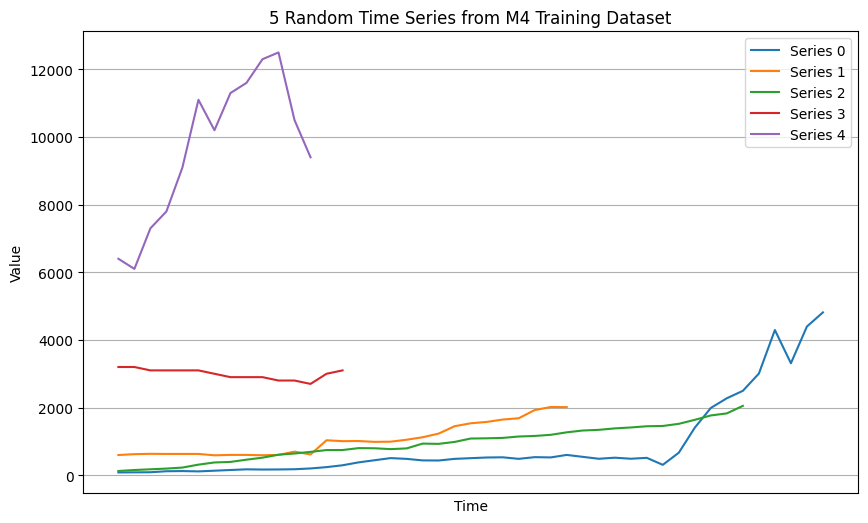

In [21]:
# Randomly select 5 time series
random_series = m4.train_df.sample(n=5, random_state=44)

# Reset the index of the DataFrame to get numerical indices
random_series_reset_index = random_series.reset_index(drop=True)

# Plot each time series on a single graph
plt.figure(figsize=(10, 6))
for index, row in random_series_reset_index.iterrows():
    plt.plot(row.index, row.values, label=f'Series {index}')

plt.title('5 Random Time Series from M4 Training Dataset')
plt.xlabel('Time')
plt.xticks([])
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Let's create a heat map to visualize the distribution of values across the time series in the dataset. In this heat map, each row will correspond to a different time series, while each column will correspond to a different time point. This will allow us to see how the values change over time across different time series.

To make the visualization more interpretable, I will randomly select a subset of 100 time series from the dataset instead of using the entire dataset. This will make it easier to observe any patterns or trends in the data.

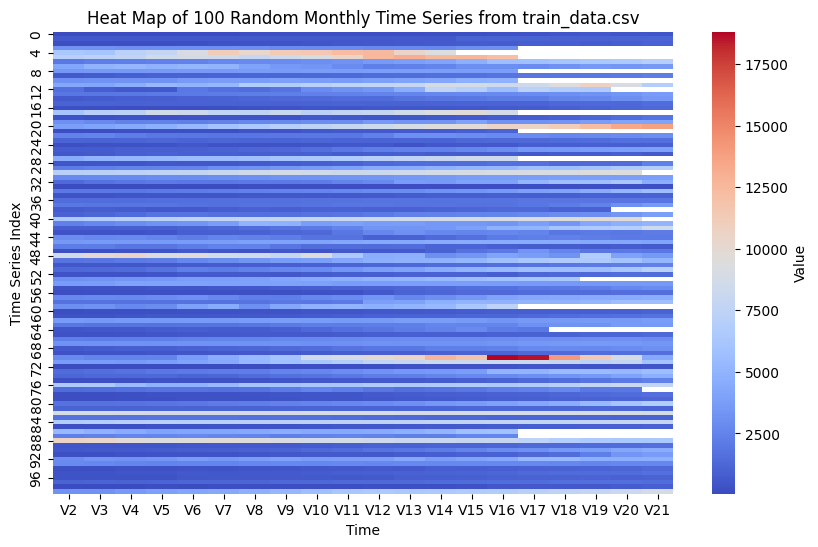

In [22]:
# Randomly select 100 time series
subset = m4.train_df.sample(n=100, random_state=44)


# Reset the index of the DataFrame to get numerical indices
subset_int_index = subset.reset_index(drop=True)
subset_int_index = subset_int_index.drop(columns= subset_int_index.columns[20:] ) 


# Generate a heat map
plt.figure(figsize=(10, 6))
sns.heatmap(subset_int_index, cmap='coolwarm', cbar_kws={'label': 'Value'})
plt.title('Heat Map of 100 Random Monthly Time Series from train_data.csv')
plt.xlabel('Time')
plt.ylabel('Time Series Index')
plt.show()


In the heat map above, each row corresponds to a different time series, and each column corresponds to a different time point. The color represents the value of the time series at each time point, with darker red colors indicating higher values and darker blue colors indicating lower values.

This visualization allows us to observe the distribution of values across different time series and time points, providing a high-level overview of the dynamics in the dataset.

### Define the Model

In this notebook we will define a Generic mode which is sufficiently deep to capture the dynamics of the time series in the dataset. The model will be trained using the Adam optimizer, with a learning rate of 1e-5. The model will be trained for 1000 epochs, with a batch size of 1024.

We mirror or the most part the N-BEATS paper's choice of hyperparameters to ensure a fair comparison between the two models.

- *Generic N-BEATS*:
    - *Number of stacks*: 10
    - *Number of blocks per stack*: 1 
    - *Number of layers*: 4
    - *Width of layers*: 512
    - *Learning rate*: 1e-5
    - *Batch size*: 1024
    - *Epochs*: 1000
    - *Share Weights*: False
    - *Loss function*: `SMAPELoss`
    - *Optimizer*: `AdamW` (Slightly faster than `Adam`)
    - *Activation*: `LeakyRELU` (Slightly faster than `RELU`)

The Symmetric Mean Absolute Percentage Error (SMAPE) is a commonly used loss function, especially in time series forecasting, because of its easy interpretability. It measures the accuracy of a forecast by computing the symmetrically scaled percentage error. Unlike Mean Absolute Percentage Error (MAPE), SMAPE has a bounded range [0, 200], which can be more desirable in some settings.

The formula for SMAPE between two vectors \( \mathbf{y} \) (actual values) and \( \hat{\mathbf{y}} \) (predicted values) for \( n \) data points is given by:

$$
{SMAPE}(\mathbf{y}, \hat{\mathbf{y}}) = \frac{200}{H} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{(|y_i + \hat{y}_i|)/2}
$$

where:
- $y_i$ is the actual value for the $i$-th data point,
- $\hat{y}_i$ is the predicted value for the $i$-th data point,
- $n$ is the total number of data points.
- $H$ is the forecasting horizon.

The division by $(|y_i + \hat{y}_i|)/2$ is what makes the percentage error symmetric. This term normalizes the error based on the magnitudes of the actual and predicted values, which helps in bringing a balance, especially when the actual value $ y_i $ is small.

The network is very large (10 stacks) and will take a long time to train. However, the model capacity is needed to capture the breadth and depth of the time series in the dataset.


In [23]:
# Set model hyperparameters
optimizer_name = 'AdamW'
loss = 'SMAPELoss'
activation = "LeakyReLU"
weight_share = True
learning_rate = 1e-4
thetas_dim = 5
n_blocks_per_stack = 1
n_stacks = 10
forecast_multiplier = 4
backcast_length = m4.forecast_length * forecast_multiplier  
no_val = False

# Set trainer hyperparameters
batch_size = 2048 # N-BEATS paper uses 1024
max_epochs = 30


# Set precision to 32 bit
torch.set_float32_matmul_precision('medium')


stacks = ["Generic"]
stack_types = stacks * n_stacks

model = NBeatsNet (
  backcast_length = backcast_length,
  forecast_length = m4.forecast_length, 
  stack_types = stack_types,
  n_blocks_per_stack = 1,
  share_weights = True, 
  thetas_dim = 5,      
  loss = 'SMAPELoss',
  active_g = True,
  no_val=no_val,
  activation=activation,
  optimizer_name=optimizer_name,
) 

model_id="".join(stacks)
name = f"{model_id}{seasonal_period}{category}[{backcast_length},{m4.forecast_length}]" 
print(f"Model Name : {name}\n")

Model Name : GenericYearlyAll[24,6]



### Train the Model  

This will take a while depending on your available hardware, the number of epochs, the number of trainable parameters, and the size of the dataset.

In [24]:
trainer = get_trainer(name, max_epochs, subdirectory=dataset_id, no_val=no_val)
dm = ColumnarCollectionTimeSeriesDataModule(
  train_data, 
  backcast_length=backcast_length, 
  forecast_length=m4.forecast_length, 
  batch_size=batch_size,
  no_val=no_val
)

trainer.fit(model, datamodule=dm)
trainer.validate(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/M4\GenericYearlyAll[24,6]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | SMAPELoss  | 0     
1 | stacks  | ModuleList | 8.0 M 
---------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
32.139    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 59/59 [00:02<00:00, 24.49it/s, v_num=0, train_loss=9.350, val_loss=13.90]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 59/59 [00:02<00:00, 24.48it/s, v_num=0, train_loss=9.350, val_loss=13.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 63.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    13.869871139526367     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 13.869871139526367}]

To get a better model to test against the M4 dataset, you would probalby want to retrain your model several times and then combine the predictions of each model(through median, mean, or other method) into an ensemble model.  You can train against the full training dataset by setting no_val = True.  This will use the entire dataset for training and cause the model to skip the validation step in training.

### Test the Model

Finally we test the model against the unseen test data.  The test data is the final {backcast_length} insample data points from the M4 dataset of each time series merged with the first {forecast_length} out of sample data points from test_data.  

In [25]:
# Test the model with the in-sample data from the training set 
# merged with the out-of-sample data from the test set
test_dm = ColumnarCollectionTimeSeriesTestDataModule(
  train_data, 
  test_data, 
  backcast_length=backcast_length, 
  forecast_length=m4.forecast_length, 
  batch_size=batch_size
)
trainer.test(model, datamodule=test_dm)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 56.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    13.574835777282715     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 13.574835777282715}]